In [279]:
# for each grids, calculate CBD Index. CBD Index represents two;
# 1. CBDness
# 2. How each grid is similar to other grids in CBD Boundary

# for example, suppose there is very high building with sufficient people, business factor((1)suffices), 
# but if that building is not similar to other buildings around((2)not suffices) CBD Index must show low
# (=like Lionel messi in the amateur league, not in Ligue 1 league)

#### Import Lib

In [280]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.wkt import loads
import constant as c
from pyproj import CRS
import sys;sys.path.append('../')
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from scipy.stats import norm

In [281]:
# then read the data
df_2020 = pd.read_csv('../asset/preprocess/df_2020.csv', index_col=0)
df_2020['geometry_grids'] = df_2020['geometry_grids'].apply(lambda x: loads(x))
df_2021 = pd.read_csv('../asset/preprocess/df_2021.csv', index_col=0)
df_2021['geometry_grids'] = df_2021['geometry_grids'].apply(lambda x: loads(x))
df_2022 = pd.read_csv('../asset/preprocess/df_2022.csv', index_col=0)
df_2022['geometry_grids'] = df_2022['geometry_grids'].apply(lambda x: loads(x))

crs = 'EPSG:5179'  # Specify the coordinate reference system
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=df_2020['geometry_grids'], crs=crs)
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=df_2021['geometry_grids'], crs=crs)
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry=df_2022['geometry_grids'], crs=crs)

gdf_2020_scbd = gdf_2020[gdf_2020['sigungunm'].isin(c.SCBD_NMS)]
gdf_2020_gbd = gdf_2020[gdf_2020['sigungunm'].isin(c.GBD_NMS)]
gdf_2020_ybd = gdf_2020[gdf_2020['sigungunm'].isin(c.YBD_NMS)]
gdf_2021_scbd = gdf_2021[gdf_2021['sigungunm'].isin(c.SCBD_NMS)]
gdf_2021_gbd = gdf_2021[gdf_2021['sigungunm'].isin(c.GBD_NMS)]
gdf_2021_ybd = gdf_2021[gdf_2021['sigungunm'].isin(c.YBD_NMS)]
gdf_2022_scbd = gdf_2022[gdf_2022['sigungunm'].isin(c.SCBD_NMS)]
gdf_2022_gbd = gdf_2022[gdf_2022['sigungunm'].isin(c.GBD_NMS)]
gdf_2022_ybd = gdf_2022[gdf_2022['sigungunm'].isin(c.YBD_NMS)]

In [282]:
# Setting COLS
SIM_CAL_COLS = c.SIM_CAL_COLS
STANDARDIZE_COLS = c.STANDARDIZE_COLS
PP_COLS = c.PP_COLS
BS_COLS = c.BS_COLS
BD_COLS = c.BD_COLS

#### Experiment Settings / Get Data

In [325]:
YEAR    = 2022
CBD_NM  = "gbd"

In [326]:
fname = f"{CBD_NM}_{YEAR}.csv"
clus  = pd.read_csv(f'../asset/experiment/cluster/{fname}') 
gwrw  = pd.read_csv(f'../asset/experiment/gwr/{fname}')
gwrw['geometry_grids'] = gwrw['geometry_grids'].apply(lambda x: loads(x))
gwrw = gpd.GeoDataFrame(gwrw, geometry='geometry_grids')
crs = CRS.from_epsg(5179)
gwrw = gwrw.set_crs(crs)
gdf_index = gwrw.copy()

# get init gwrw(For init grids)
init_grid_gdf = clus[clus['phase'] == 0]
init_grid_idxs = list(init_grid_gdf.grid_idx.values.astype(int))
init_gwrw = gwrw[gwrw['grid_idx'].isin(init_grid_idxs)]

# get cluster gwrw(For all grids in cluster)
grid_idxs = list(clus.grid_idx.values.astype(int))
gwrw = gwrw[gwrw['grid_idx'].isin(grid_idxs)]

# get init coefficient values
col_nms = list(init_gwrw.columns)
gwr_columns = [col for col in col_nms if col.startswith('gwr_')]
gwr_columns.remove('gwr_r2') # we get only coef names
coef = init_gwrw[gwr_columns].mean()
print(coef.gwr_const + coef.values[1:].mean())
coef

-2.7202931918175306


gwr_const        -3.107450
gwr_bs_elct       0.030841
gwr_bs_ebit      -1.150074
gwr_bd_height     0.560496
gwr_bd_vintage    0.618437
gwr_pp_od         3.589284
gwr_pp_pop       -1.326041
dtype: float64

#### Calculate CBD Index

In [327]:
# coef
# gwrw.head(5)

In [328]:
# 1) CBD Ness
cbdnesses = []
for i in range(len(gwrw)):   
    row_data = gwrw.iloc[i]
    cbdness = coef.gwr_const 
    for coef_col_nm in list(coef.index):
        if coef_col_nm == 'gwr_const': 
            pass 
        else:
            col_nm = coef_col_nm[4:]
            cbdness += norm.cdf(row_data[col_nm]) * coef[coef_col_nm]
            
    # cbdness = max(cbdness, 0)
    cbdnesses.append(cbdness)
gwrw['cbdness'] = cbdnesses

# 2) Similarity Index
mean_gwrw = gwrw[STANDARDIZE_COLS].mean()
abs_diffs = gwrw[STANDARDIZE_COLS].sub(mean_gwrw).abs()
row_diffs = list(abs_diffs.mean(axis=1))
row_sims = [math.exp(-diff/10) for diff in row_diffs]
gwrw['sim'] = row_sims

# 1) * 2) -> CBD Index 
gwrw['cbdi'] = gwrw['cbdness'] * gwrw['sim']
gwrw['cbdi'] = gwrw['cbdi'] / gwrw['cbdi'].max() # scale from 0 to 1

<Axes: >

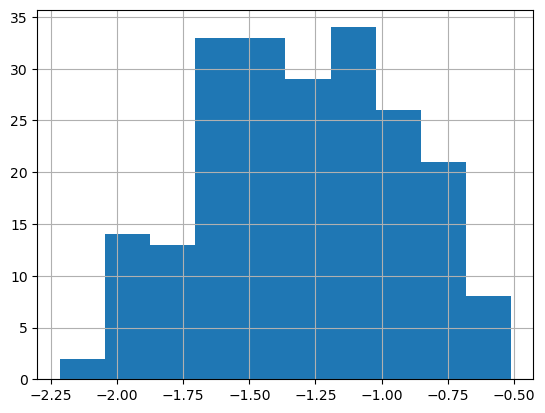

In [329]:
gwrw['cbdness'].hist()

In [321]:
gwrw['cbdi'].max()

1.0

In [311]:
gwrw[['grid_idx', 'geometry_grids', 'sim', 'cbdness', 'cbdi']].explore(column = 'cbdi', cmap = 'coolwarm')

ValueError: max() arg is an empty sequence